# Spanning Tree with Message Passing

In [16]:
%matplotlib inline

In [8]:
import networkx as nx

Spanning tree of an undirected graph is a tree which includes all the vertices of the graph with a minimum number of possible edges.

One application of spanning trees is in the [Spanning Tree Protocol (STP)](https://www.wikiwand.com/en/Spanning_Tree_Protocol), where we want to avoid loops in the topology.

We want to construct an algorithm that relies on messages passed between nodes and not the knowledge of the overall topology.

### Identifying the "root"

The idea is to minimize the distance from each node to the "root". The choice of root does not matter. For simplicity we'll designate the node with the lowest ID as the root.

This suggests that initially each node can think of itself as the root node and then send the state of its knowledge to neighbors.

### Avoiding loops

#### 3 node [clique](https://www.wikiwand.com/en/Clique)

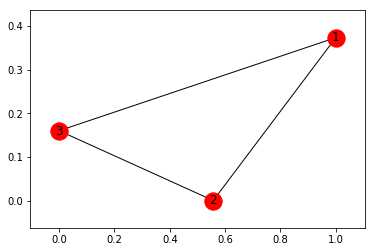

In [19]:
clique = nx.Graph()
clique.add_nodes_from([1, 2, 3])
clique.add_edges_from([(1, 2), (1, 3), (3, 2)])

nx.draw_networkx(clique)

In this case we should remove the link between 2 and 3. In that case 3 and 2 have the minimum distance of 1 to the root node 1.

#### 4 node [cycle](https://www.wikiwand.com/en/Cycle_graph)

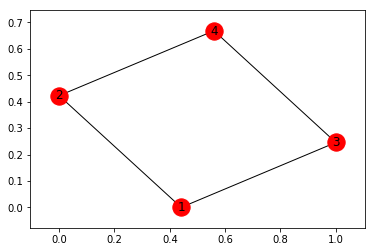

In [28]:
cycle = nx.Graph()
cycle.add_nodes_from([1, 2, 3, 4])
cycle.add_edges_from([(1, 2), (1, 3), (3, 4), (2, 4)])

nx.draw_networkx(cycle)

In this case 4 has 2 paths to root (i.e. 1). 4 can either go through 2 or it can go through 3. To break this loop we need to pick one. Let's say that we always want the node to go through the lower ID node to break the tie. Therefore our algorithm should be able to deactivate the link between 3 and 4.

### Processing messages

In general upon receiving a message a node needs to take a subset of these actions:
- **Update** the local knowledge
- **Activate** link(s) to neighbor(s)
- **Deactivate** link(s) to neighbor(s)
- **Inform** a subset of neighbors of a change

For instance a simple scenario is when a node receives a message that suggests that the originator of the message knows of a root that has a lower switch ID than the current node (e.g. message's root < node's root). In this case we have to:
- Update the current node's root
- Activate the link to the message's originator (if previously deactivated)
- Inform all neighbors except for the message's originator of the changes to propagate the newfound knowledge.

The rest of this algorithm revolves around working through different scenarios and taking the appropriate set of actions.

### Test cases

A number of test cases helped me with debugging the following issues with my algorithm:
#### 1. Makes sure that you're not dropping any links that you do not have to.

##### 1.1 Simple
```
1 --- 2 --- 3
```

##### 1.2 No loop
```
1 --- 2 --- 3 --- 4
|           |     
|           |     
5     6 --- 7 --- 8
|     |           |
|     |           |
9     10 -- 11    12
      |     
      |        
      13
```

#### 2. Break ties appropriately in a 4 node cycle

##### 2.1 Single loop
```
1 --- 2
|     |
|     |
3 --- 4
```

#### 3. Handle 3 node cliques
##### 3.1 Complex loop
```
1 --- 2 --- 3 --- 4
|     |     |     |
|     |     |     |
5 --- 6 --- 7 --- 8
|     |     |     |
|     |     |     |
9 --- 10 -- 11 -- 12
      |     |
      |     |
       \   /
        13
```

#### 4. Make sure you propagate the root and update nodes all the way 
##### 4.1 Loop with tail
```
2 --- 7
|     |
|     |
3 --- 5 --- 9 --- 11 --- 1 
```

### Here are a few other test topologies that can help you tease out other edge cases

#### Topology described [here](https://www.youtube.com/watch?v=4jXzuEu-qYE)
```
2 --- 1 --- 3
|     |   /
|     | /
6 --- 8 --- 4
  \   |
   \  |
5 --- 7
```

#### Hexagon
```
  1---2
 / \ / \
3---4---5
 \ / \ /
  6---7
```

#### Very complex
```
             11    6     8
           /   * /   * *   *
          2     3     7     10
          *     *     *     |
          4     5     1     12
          |*   * *   * *    *|
          |  13    14    15  |
          |   |\  *  *  /|   |
          |   | 16    17 |   |
          |   |   *  /   |   |
          |   |    18    |   |
          |   |   *  *   |   |
          |   | 19    20 |   |
          |   |  |*  /|  |   |
          |   |  *  X |  |   |
          *   *  |/  *|  *   *
          |   | 22    23 |   |
          |   |   \  /   |   |
          |   |    24    |   |
          |   |   *  *   |   |
          |   | 25    26 |   |
          |   |/  \  *  *|   |
          |  27    28    29  |
          |/   * /   \ *   \ |
          40    41    42    43
          *     |     *     *
          34    35    36    37
           *   / *   * *    /
             38    39    33
```